# Task 1

In [2]:
!pip3 install --user networkx
import numpy
from urllib.request import urlopen
import scipy.optimize
import random
import ast
from math import exp
from math import log
import networkx as nx
import matplotlib.pyplot as plt
import numpy
import urllib
import scipy.optimize
import random
from sklearn.decomposition import PCA
from collections import defaultdict

  Using cached https://files.pythonhosted.org/packages/bc/bb/a24838832ba35baf52f32ab1a49b906b5f82fb7c76b2f6a7e35e140bac30/decorator-4.3.0-py2.py3-none-any.whl


In [3]:
## import data
def parseDataFromFile(fname):
  for l in open("beer_50000.json").read().splitlines():
    yield ast.literal_eval(l)
print ("Reading data...")
data = list(parseDataFromFile("beer_50000.json"))
print ("done")

Reading data...
done


In [4]:
## random data
random.shuffle(data)

## split
training_data= data[:int(len(data)/3)]
vali_data= data[int(len(data)/3):2*int(len(data)/3)]
test_data= data[2*int(len(data)/3):]

In [5]:
def feature(datum):
  feat = [1, datum['review/taste'], datum['review/appearance'], datum['review/aroma'], datum['review/palate'], datum['review/overall']]
  return feat

X_train = [feature(d) for d in training_data]
y_train = [d['beer/ABV'] >= 6.5 for d in training_data]

X_vali = [feature(d) for d in vali_data]
y_vali = [d['beer/ABV'] >= 6.5 for d in vali_data]

X_test = [feature(d) for d in test_data]
y_test = [d['beer/ABV'] >= 6.5 for d in test_data]


def inner(x,y):
  return sum([x[i]*y[i] for i in range(len(x))])

def sigmoid(x):
  return 1.0 / (1 + exp(-x))

In [6]:
##################################################
# Logistic regression by gradient ascent         #
##################################################

# NEGATIVE Log-likelihood
def f(theta, X, y, lam):
  loglikelihood = 0
  for i in range(len(X)):
    logit = inner(X[i], theta)
    loglikelihood -= log(1 + exp(-logit))
    if not y[i]:
      loglikelihood -= logit
  for k in range(len(theta)):
    loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print("ll =" + str(loglikelihood))
  return -loglikelihood

# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
  dl = [0]*len(theta)
  for i in range(len(X)):
    logit = inner(X[i], theta)
    for k in range(len(theta)):
      dl[k] += X[i][k] * (1 - sigmoid(logit))
      if not y[i]:
        dl[k] -= X[i][k]
  for k in range(len(theta)):
    dl[k] -= lam*2*theta[k]
  return numpy.array([-x for x in dl])

##################################################
# Train                                          #
##################################################

def train(lam):
  theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X_train[0]), fprime, pgtol = 10, args = (X_train, y_train, lam))
  return theta

##################################################
# Predict                                        #
##################################################

def performance(theta, X, y):
  scores = [inner(theta,x) for x in X]
  predictions = [s > 0 for s in scores]
  correct = [(a==b) for (a,b) in zip(predictions,y)]
  acc = sum(correct) * 1.0 / len(correct)
  return acc

### Q 1

In [7]:
##################################################
# Validation pipeline                            #
##################################################

lam = 1.0

theta = train(lam)
acc = performance(theta, X_train, y_train)
print("lambda = " + str(lam) + ":\taccuracy of train set=" + str(acc))

acc = performance(theta, X_vali, y_vali)
print("lambda = " + str(lam) + ":\taccuracy of validation set=" + str(acc))

acc = performance(theta, X_test, y_test)
print("lambda = " + str(lam) + ":\taccuracy of test set=" + str(acc))

lambda = 1.0:	accuracy of train set=0.7205688227529101
lambda = 1.0:	accuracy of validation set=0.7206288251530061
lambda = 1.0:	accuracy of test set=0.7150227981761459


### Q 2

In [8]:
def det_perf(theta, X, y):
    scores = [inner(theta,x) for x in X]
    predictions = [s > 0 for s in scores] # output TF
    correct = [(a==b) for (a,b) in zip(predictions,y)]
    P = predictions.count(True)
    N = predictions.count(False)
    TP = [(a*b) for (a,b) in zip(predictions,correct)]
    TP = TP.count(1)
    TN = [ ((1-a)*b) for (a,b) in zip(predictions,correct)]
    TN = TN.count(1)
    FP = abs(P- TP)
    FN = abs(N- TN)
    result = [P,N,TP,TN,FP,FN]
    return result

In [9]:
result_test = det_perf(theta, X_test, y_test)
print("Positive = " + str(result_test[0]) + "\tNegative=" + str(result_test[1]) + "\tTruePositive=" + str(result_test[2]) + 
      "\tTrueNegative=" + str(result_test[3]) + "\tFalsePositive=" + str(result_test[4]) + "\tFalseNegative=" + str(result_test[5]))

Positive = 12368	Negative=4300	TruePositive=8963	TrueNegative=2955	FalsePositive=3405	FalseNegative=1345


### Q 3

If I want to assign greater importance to False Positives, then I will change the coefficient.

Firstly, I will change the f function's for parts. I will devide them into four parts. Now they are devided into two parts   $$y[i] > 0$$ $$y[i] < 0$$

I will add two judgment. So they will have four situation:$$y[i] > 0\quad and\quad X[i] \cdot \theta > 0$$
$$y[i] > 0\quad and\quad X[i] \cdot \theta < 0$$
$$y[i] < 0\quad and\quad X[i] \cdot \theta > 0$$
$$y[i] < 0\quad and\quad X[i] \cdot \theta < 0$$

Secondly, I will assign 10 times loglikelihood of the situation $y[i] < 0\quad and\quad X[i] \cdot \theta > 0$, which means False Positive.

Thirdly, I will change the Derivative of log-likelihood correspondently. Add two more judgments and change the coefficient of the False Positive.

### Q 4

In [10]:
## lambda = 0
lam = 0

theta1 = train(lam)
acc = performance(theta1, X_train, y_train)
print("lambda = " + str(lam) + ":\taccuracy of train set=" + str(acc))

acc1 = performance(theta1, X_vali, y_vali)
print("lambda = " + str(lam) + ":\taccuracy of validation set=" + str(acc1))

lambda = 0:	accuracy of train set=0.7217088683547341
lambda = 0:	accuracy of validation set=0.7209288371534861


In [11]:
## lambda = 0.01
lam = 0.01

theta2 = train(lam)
acc = performance(theta2, X_train, y_train)
print("lambda = " + str(lam) + ":\taccuracy of train set=" + str(acc))

acc2 = performance(theta2, X_vali, y_vali)
print("lambda = " + str(lam) + ":\taccuracy of validation set=" + str(acc2))

lambda = 0.01:	accuracy of train set=0.7217088683547341
lambda = 0.01:	accuracy of validation set=0.7209288371534861


In [12]:
## lambda = 0.1
lam = 0.1

theta3 = train(lam)
acc = performance(theta3, X_train, y_train)
print("lambda = " + str(lam) + ":\taccuracy of train set=" + str(acc))

acc3 = performance(theta3, X_vali, y_vali)
print("lambda = " + str(lam) + ":\taccuracy of validation set=" + str(acc3))

lambda = 0.1:	accuracy of train set=0.7215288611544461
lambda = 0.1:	accuracy of validation set=0.7210488419536781


In [13]:
## lambda = 1
lam = 1

theta4 = train(lam)
acc = performance(theta4, X_train, y_train)
print("lambda = " + str(lam) + ":\taccuracy of train set=" + str(acc))

acc4 = performance(theta4, X_vali, y_vali)
print("lambda = " + str(lam) + ":\taccuracy of validation set=" + str(acc4))

lambda = 1:	accuracy of train set=0.7205688227529101
lambda = 1:	accuracy of validation set=0.7206288251530061


In [14]:
## lambda = 100
lam = 100

theta5 = train(lam)
acc = performance(theta5, X_train, y_train)
print("lambda = " + str(lam) + ":\taccuracy of train set=" + str(acc))

acc5 = performance(theta5, X_vali, y_vali)
print("lambda = " + str(lam) + ":\taccuracy of validation set=" + str(acc5))

lambda = 100:	accuracy of train set=0.6728669146765871
lambda = 100:	accuracy of validation set=0.6689067562702508


According to the accracy shown above:

the theta with best accracy is $\theta_4$, when $\lambda$ equals 1.
    
For the performance on the test set.

In [15]:
lam = 1
acc = performance(theta4, X_test, y_test)
print("lambda = " + str(lam) + ":\taccuracy of test set=" + str(acc))

lambda = 1:	accuracy of test set=0.7150227981761459


# Task 2

### Q 5

In [16]:
with open('egonet.txt', 'r') as f2:
    data = f2.read()
ego_list = [x for x in data.split('\n')]
ego_list.remove('')

In [17]:
edges = set()
nodes = set()
a = list()
for edge in ego_list:
  x,y = edge.split(' ')
  x,y = int(x),int(y)
  edges.add((x,y))
  edges.add((y,x))
  nodes.add(x)
  nodes.add(y)

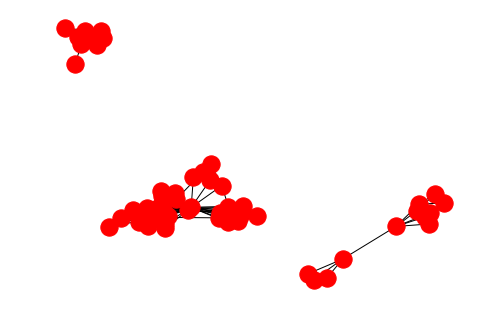

<Figure size 432x288 with 0 Axes>

In [18]:
G = nx.Graph()
for e in edges:
  G.add_edge(e[0],e[1])
nx.draw(G)
plt.show()
plt.clf()

In [19]:
# Get the number of connected components
num_components = nx.number_connected_components(G)
print(num_components)

3


In [20]:
# Get the number of nodes in the largest connected component
G_large = max(nx.connected_components(G), key = len)  ####question???
num_nodes_large = len(G_large)
print(num_nodes_large)

40


### Q 6

In [61]:
GL= max(nx.connected_component_subgraphs(G), key = len)

In [187]:
G_set = list(GL.nodes())
G_set.sort()

In [63]:
c1=list()
c2=list()
for i in range(int(len(G_set))):
    if i < int(len(G_set)/2):
        c1.append(G_set[i])
    else:
        c2.append(G_set[i])

In [64]:
N_cut = (nx.cut_size(GL, c1, c2)/sum([GL.degree(v) for v in c1])+nx.cut_size(GL, c1, c2)/sum([GL.degree(v) for v in c2]))/2

In [58]:
N_cut

0.42240587695133147

### Q 7

In [188]:
## initial
c1=list()
c2=list()
for i in range(int(len(G_set))):
    if i < int(len(G_set)/2):
        c1.append(G_set[i])
    else:
        c2.append(G_set[i])
        
def N_cut(c1,c2):
    N = (nx.cut_size(GL, c1, c2)/sum([GL.degree(v) for v in c1])+nx.cut_size(GL, c1, c2)/sum([GL.degree(v) for v in c2]))/2
    return N


## greedy 

norcut=list([1,0.9])
n = -1
while norcut[-2] - norcut[-1] >= 0:
    c3=list()
    
    for i in range(len(c1)):
        c4, c5= c1, c2
        com = c4[i]
        c5.append(c4[i])
        del c4[i]
        c3.append(N_cut(c4,c5))
        c1.insert(i,com)
        c2.pop()
    for i in range(len(c2)):
        c4, c5= c1, c2
        com = c5[i]
        c4.append(c5[i])
        del c5[i]
        c3.append(N_cut(c4,c5))
        c2.insert(i,com)
        c1.pop()
    norcut.append(min(c3))
    n= n+1
    
    if c3.index(min(c3)) <= 19:
        c2.append(c1[c3.index(min(c3))])
        del c1[c3.index(min(c3))]
        print(c1)
        print(c2)
    else:
        c1.append(c2[c3.index(min(c3))])
        del c2[c3.index(min(c3))]
        print(c1)
        print(c2)
print('We need to Iterate for '+str(n)+' times and our best normalized cut cost is  ' + str(norcut[-2]))

[697, 703, 708, 713, 719, 745, 747, 753, 769, 772, 774, 798, 800, 803, 804, 805, 810, 811, 819]
[823, 825, 828, 830, 840, 856, 861, 863, 864, 869, 876, 878, 880, 882, 884, 886, 888, 889, 890, 893, 729]
[697, 703, 708, 713, 719, 745, 747, 753, 769, 772, 774, 798, 800, 803, 805, 810, 811, 819]
[823, 825, 828, 830, 840, 856, 861, 863, 864, 869, 876, 878, 880, 882, 884, 886, 888, 889, 890, 893, 729, 804]
[697, 703, 708, 713, 719, 745, 747, 753, 769, 772, 774, 798, 800, 803, 805, 810, 811, 819, 729]
[823, 825, 828, 830, 840, 856, 861, 863, 864, 869, 876, 878, 880, 882, 884, 886, 888, 889, 890, 893, 804]
[697, 703, 708, 713, 719, 745, 747, 753, 769, 772, 774, 798, 800, 803, 805, 810, 811, 819]
[823, 825, 828, 830, 840, 856, 861, 863, 864, 869, 876, 878, 880, 882, 884, 886, 888, 889, 890, 893, 804, 729]
We need to Iterate for 3 times and our best normalized cut cost is  0.3068340306834031


And the best way to split this is 

[697, 703, 708, 713, 719, 745, 747, 753, 769, 772, 774, 798, 800, 803, 805, 810, 811, 819, 729]

[823, 825, 828, 830, 840, 856, 861, 863, 864, 869, 876, 878, 880, 882, 884, 886, 888, 889, 890, 893, 804]

### Q 8

In [78]:
norcut[-2] - norcut[-1] >= 0

True

In [29]:
c9 =[825,861,863,864,876,878,882,884,886,888,889,893,729,804]

In [35]:
c8 =[697,703,708,713,719,745,747,769,772,774,798,800,805,810,811,819,828,830,823,840,880,803,869,890,753,856]

In [189]:
c10 = c8.copy()

In [190]:
c10

[697,
 703,
 708,
 713,
 719,
 745,
 747,
 769,
 772,
 774,
 798,
 800,
 805,
 810,
 811,
 819,
 828,
 830,
 823,
 840,
 880,
 803,
 869,
 890,
 753,
 856]

In [191]:
del c10[0]

In [192]:
len(c8)

26